In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as opt


In [14]:
raw_data = pd.read_csv('3.csv')
raw_data = pd.DataFrame(raw_data).to_numpy()
raw_time = raw_data[:,0] + 10 - 1.41
raw_v = (raw_data[:,1] + .06) / 2


In [15]:
v_interp = interp1d(raw_time, raw_v, kind="linear")

start_time = 0
stop_time = raw_time[-1]
step_size = 0.05
time = np.arange(start_time, stop_time, step_size)

v = v_interp(time)


As discussed in our methods sections, we have recreated a circuit that effectively integrates the input voltage. To explore this behavior, we will integrate the (non-normalized) sinc function, which is defined as $sinc(t) = \frac{\sin(t)}{t}$. This is an interesting function to integrate for multiple reasons, formost among them being that the integral of the function has no elementary representation. Additionally, the sinc function is extremely prevalent in fourier and signal analysis, as it is the fourier transform of a rectangular function. (cited wikepedia sinc function, please take care of this when transfering) Unfortunately we did not get to explore the implications of this in our analysis here. Note that as there is no elementary representation of the integral, all theoretical calculations of the integral are computed using scipy's numerical integration regimen. (Both the Theoretical Output and Fitted Output, mentioned later, rely on this method).

The output of our integrator can be theoretically calulated via the following equation:
$$ V_{out} = \int_{0}^{t} \frac{-V_{in}}{RC} \,dt + c $$
where c is the output voltage at t=0, RC is the time constant of our integrator circuit, and $V_{in}$ is the the voltage supplied to the circuit. 
We produced $V_{in}$ with our arbitrary function generator producing a signal modeled by $\frac{sinx}{x}$, with an maximum amplitude of 3.287 V (i.e. a peak voltage of 4 V), and a "frequency" of .64. While we are trying to integrate the sinc function from zero to infinity, this is obviously impossible so we decided that 32 cycles would get us a close-enough estimation. Thus we gave the signal generator a sinc fucntion defined on the range t=0 to the 32nd "cycle," and set the frequency of the signal generator to 20 mHz. This tells us that we will have 32 cycles in 50 seconds, or "frequency" of .64 Hz, and a "angular velocity" for the sine fucnction of $2\pi(.64) = 4.02$. 
Note that due to an unfortunate data collection mistake, the input signal recorded by the oscilloscope was not saved. Please see the attatched image to see exactly what the oscillosope saw in one of our trials. (Figure showing integration).

In [16]:
def sinc(t, a, b, c):
    return (a / b) * np.sin(b * t) / t + c

def sinc_int(t, a, b, c):
    return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])

e = [0.01 for i in range(len(v))]

def norm_res(predicted, observed, errors):
    return (observed-predicted) / errors


In [17]:
v_pred_int = sinc_int(time, -3.13, 4.02, 0)
v_pred_int[0] = 0

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_42166/1477230409.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a / b) * np.sin(b * t) / t + c
/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_42166/1477230409.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])


In [18]:
lin_opt, lin_cov = opt.curve_fit(sinc_int, time[1:], v[1:], p0=[-3.13, 4.02, .1])

a, b, c = lin_opt
da, db, dc = np.sqrt(np.diag(lin_cov))

v_pred_fit = sinc_int(time, a, b, c)
v_pred_fit[0] = 0

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_42166/1477230409.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a / b) * np.sin(b * t) / t + c
/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_42166/1477230409.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])


In the below plot, the Integrator Input generated by our arbitrary waveform generator (i.e. $V_{in}$) is given wrt time by the function $3.287\frac{\sin(4.02t)}{4.02t}$. Note that the Integrator Input shown on our graph is theoretically computed and not collected from data as discussed above. Our integrator had a measured RC time constant of 1.05 and thus the integral that our circuit should be computing is: $ \frac{3.287}{1.05} \int_{0}^{50} \frac{\sin(4.02t)}{4.02t} \,dt$. This exact function is plotted plotted below as the Theoretical Integrator Output. Note that this function was NOT fitted to our data, and is completely theoretically computed. Finally, the voltage measured by our oscilloscope, or our Experimental Integrator Output, is also plotted. Note that in our data processing we have already removed the voltage offset at t=0 (i.e. our integration constant shown in the formula above) so this does not need to be taken into account. Additionally, we had an issue in our data analysis where our voltage measurements were exactly twice that of our theoretical values. Upon reviewing our experimental settup, we realized this was due to the impedance setting out our functon generator, so we went back and divided our voltage readings by 2. 

In [1]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15, 7.5), sharex=True)
f.tight_layout()

ax0.plot(time, sinc(time, 3.13, 4.02, 0), 'green', label=r'Integrator Input')
ax0.plot(time, v_pred_int, label='Theoretical Integrator Output')
ax0.plot(time, v, label='Experimental Integrator Output')
ax1.plot(time, v_pred_int)
ax1.plot(time, v)
ax0.legend()
ax0.set_title('Exp 2: Integrator Behavior for sinc(t), Voltage Vs. Time \n Comparison of Theoretical and Experimental Integrator Outputs')
ax0.set_ylabel('Voltage (V)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlabel('Time (s)')
ax1.set_ylim(-1.53, -1.05)

plt.show()


NameError: name 'plt' is not defined

Visually inspecting the above graph, we can see that the function is a very close fit, but slightly vertically offset. To confirm the degree of agreement, we can conduct a Chi Squared analysis. Looking at the data collected from the oscilloscope, the minimum step size was 0.04 V. This implies that our precision error on the voltage readings is 0.01 V (preicison error is half of minimum step size and we divided our voltage readings by 2). Seeing as we did not fit this theoretical plot, our degrees of freedom is simply equal to our number of datapoints. With this information, we can construct a normalized residuals plot and calculate our reduced chi squared, $\tilde\chi^2 = 14.85$. This indicates that our model does not completely capture our data, as expected. Though it is also not horrible. We can visually see the offset in the residuals plot, and no terribly significant other patters can be seen. 

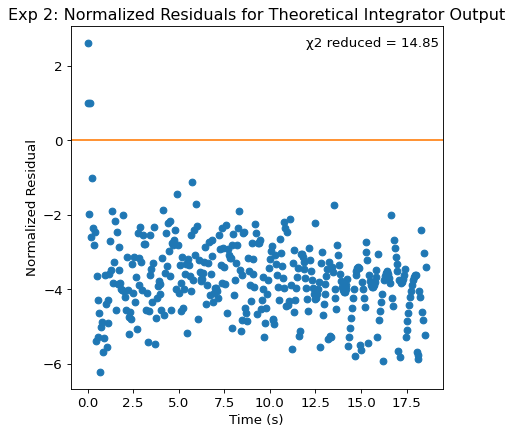

In [20]:
res = norm_res(v_pred_int, v, e)

chi_sq = np.sum(res ** 2)
red_chi_sq = chi_sq / (len(v))

# Plotting residuals time!

plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

plt.scatter(time, res)
plt.axhline(color='tab:orange')

plt.title("Exp 2: Normalized Residuals for Theoretical Integrator Output")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Residual")
plt.text(12, 2.5, f"χ2 reduced = {round(red_chi_sq, 2)}")
plt.show()



Next we plot the Fitted Integrator Output against the Experimental Output. The Fitted Output was calculated using the Scipy curve fit method, modeled by the theoretical integral of a sinc function while varying the amplitude, vertical offset, and "angular velocity" of the sinc function being integrated. Visually, this produces an all but perfect fit. Note that the all three fitting values were calculated to be quite similiar to the actual values. However the errors from the covariance matrix are not large enough to account for the discrepancies on their own. Agreement between the calcualted and actual values would be dependent on the errors in the actual values, which at this point are all but impossible to estimate. (For instance, the error in angular velocity would be dependent on the phase error of the AFG, which we could not find.) While we cannot conduct an acceptance test between these values, reasons for their slight varaition from actual values will be briefly discussed later while talking about sources of noise and error. For now, we can use these calculated values to definitively show that our integrator circuit is, in fact, integrationg SOME sinc function very well.

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_42166/1477230409.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (a / b) * np.sin(b * t) / t + c


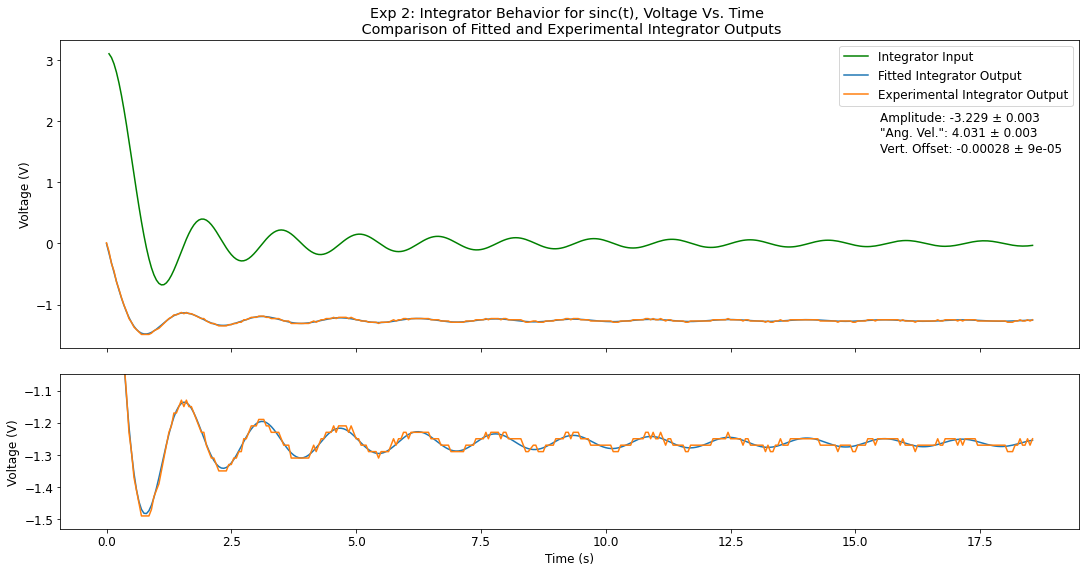

In [24]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15, 7.5), sharex=True)
f.tight_layout()

ax0.plot(time, sinc(time, 3.13, 4.02, 0), 'green', label=r'Integrator Input')
ax0.plot(time, v_pred_fit, label='Fitted Integrator Output')
ax0.plot(time, v, label='Experimental Integrator Output')
ax1.plot(time, v_pred_fit)
ax1.plot(time, v)
ax0.legend()
ax0.set_title('Exp 2: Integrator Behavior for sinc(t), Voltage Vs. Time \n Comparison of Fitted and Experimental Integrator Outputs')
ax0.set_ylabel('Voltage (V)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlabel('Time (s)')
ax1.set_ylim(-1.53, -1.05)
ax0.text(15.5, 2, f"Amplitude: {round(a, 3)} ± {round(da, 3)}")
ax0.text(15.5, 1.75, f"\"Ang. Vel.\": {round(b, 3)} ± {round(db, 3)}")
ax0.text(15.5, 1.5, f"Vert. Offset: {round(c, 5)} ± {round(dc, 5)}")

plt.show()


Our residual plot for this fit shows an exceptional level of agreement, with no pattern in the residuals. With the same 0.01 V  error, we can calulace our Chi Squared, $\tilde\chi^2 = 0.77$. From this we can confidently conclude that this fits captures the data very well. Note that this value is a bit low considering our degree of freedom, so error may be slightly oversestimated. But seeing this is the best Chi Squared we have gotten for any experiment all semester, we will be happy. 

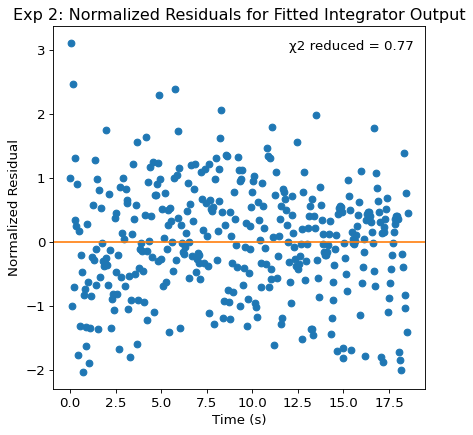

In [10]:
res = norm_res(v_pred_fit, v, e)

chi_sq = np.sum(res ** 2)
red_chi_sq = chi_sq / (len(v) - 3)

# Plotting residuals time!

plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

plt.scatter(time, res)
plt.axhline(color='tab:orange')

plt.title("Exp 2: Normalized Residuals for Fitted Integrator Output")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Residual")
plt.text(12, 3, f"χ2 reduced = {round(red_chi_sq, 2)}")
plt.show()


Having shown that our integrator is in fact producing a output voltage that is modeled by the integral of a sinc function, we now want to see if our voltage output converges to the expected limit of the integral. From our trials, we found that our output converged, repeatedly, to 2.30±0.02V. Here we are ignoring assuming error is only due to the precision error of the oscilloscope readings, and we are ignoring our repeated measurements. Our expected value can be found from $ \frac{3.287}{1.053} \int_{0}^{50} \frac{\sin(4.02t)}{4.02t} \,dt = 1.216$. The error is hard to estimate here, however if we assume that the AFG has negligible frequency and amplitude error, then the major contributor to error will be our RC time constant, which doing error propogation with our measured values and the precision error of the mutimeter gets us an error on the of ~0.001. With these low errors, our expected value of 1.216±0.001V does not agree with our measured value of 2.30±0.02V. 

While these values do not agree, they were suprising close, and there are many sources of error other than precision error that were contributing. The main source of error is likely drifts in our voltage due to very slight offsets in our inputs. We are integrating our function over 50 seconds, which means that a voltage offset in our input from grounds of as little as 0.002V would have produced the 0.1V disagreement between our values. Note that this offset is not exclusively due to the AFG either, if somehow our functionion generator and DC power supply did not perfectly agree on ground (due to attenuations in the BNC cables, slight inaccuracies between the DC supply and AFG compounding, etc.) this would also give us our votlage offset. A way to improve this source of error would be to increase the frequency of the function generator, giving voltage offsets less time to compound. 

Of course, an obvious source of error is simply that our circuit components, including our op-amp, are not ideal. Parasitic capacitanes or resistances in our cables and circuit components can all couse issues. Noise from our op-amp or DC power supply could also cause an issue. There could have been some inherent voltge offset in our op-amp due to a manufacturing error. Additionally, our op-amp could have been filtering out certain frequency components of our sinc function, skewing our results. (Though this would be an interesting avenue to explore, it would likely not explain our disagreement here as our measured value was HEIGHER then expected which can not be explained by filtering bahavior.)